<a href="https://colab.research.google.com/github/rifqoi/BERT-Sentiment-Analysis/blob/main/11-indoberttweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
!wget https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt -O stopword.txt
!wget https://cdn.discordapp.com/attachments/818681954303868938/995913295154393148/bismillah.json

--2022-07-11 05:58:44--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49923 (49K) [text/plain]
Saving to: ‘kamus_alay.csv.1’

kamus_alay.csv.1    100%[===================>]  48.75K  --.-KB/s    in 0.001s  

2022-07-11 05:58:45 (74.9 MB/s) - ‘kamus_alay.csv.1’ saved [49923/49923]

--2022-07-11 05:58:45--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 

In [2]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict
import string

# NLP
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

import tensorflow as tf

from transformers import TFBertForSequenceClassification, BertConfig, BertTokenizer, TFAutoModelForSequenceClassification, TFAutoModel
from transformers import InputExample, InputFeatures
import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Import data
df = pd.read_json("bismillah.json")

In [5]:
df = df.sample(frac=1)

In [6]:
df = df[["tweets", "sentiment"]]
df

,tweets,sentiment
1983,kok ga ikut photo an ya .. pdhal ini di Jakart...,Negative
335,Cobalah survei lokasi ini. Dengan dukungan d...,Positive
1548,Pelan Tapi Pasti jangan sampai grasa Grusu tdk...,Positive
642,Ketua DPRD DKI Jakarta Prasetyo Edi Marsudi me...,Neutral
414,Selain Presiden Menteri BUMN juga mendukung ...,Positive
...,...,...
2645,Jelang Formula E Jakarta: Sirkuit Belum Rampun...,Negative
1439,Nis lihat nih rakyat jakarta. Masa lu telantar...,Negative
3072,"Kasus Formula E giimana, sama kasus lebih baya...",Negative
678,"bagi saya yang orang luar jakarta,jkt aneh saj...",Negative


In [7]:
df.tweets = df.tweets.apply(lambda x: x.lower())
df

,tweets,sentiment
1983,kok ga ikut photo an ya .. pdhal ini di jakart...,Negative
335,cobalah survei lokasi ini. dengan dukungan d...,Positive
1548,pelan tapi pasti jangan sampai grasa grusu tdk...,Positive
642,ketua dprd dki jakarta prasetyo edi marsudi me...,Neutral
414,selain presiden menteri bumn juga mendukung ...,Positive
...,...,...
2645,jelang formula e jakarta: sirkuit belum rampun...,Negative
1439,nis lihat nih rakyat jakarta. masa lu telantar...,Negative
3072,"kasus formula e giimana, sama kasus lebih baya...",Negative
678,"bagi saya yang orang luar jakarta,jkt aneh saj...",Negative


In [8]:
count = 0
for x in df.itertuples():
  if count == 10:
    break
  print(x.tweets)
  count += 1

kok ga ikut photo an ya .. pdhal ini di jakarta loh.. eh ngemeng2 bambu n kayu pondasi formula e sdh cukup blm??
cobalah  survei lokasi ini. dengan dukungan  dan  mungkin ini cocok utk venue formula e. sekalian dunia juga tahu bahwa jakarta bukan cuma monas dan sekitarnya.
pelan tapi pasti jangan sampai grasa grusu tdk tercapai ekspatasi   formula e dn moto gp sama sama for merah putih ,harusnya berkeadilan mendukung semuanya   jakarta itu indonesia lombok pun sama indonesia
ketua dprd dki jakarta prasetyo edi marsudi menyebut lokasi revitalisasi gerbang ancol sisi timur sama dengan titik sirkuit formula e.  #tempometro
selain presiden  menteri bumn  juga mendukung gelaran formula e yang akan diselenggarakan di jakarta.   harapannya formula e akan bikin ngegas perekonomian dari sisi pariwisata. 😎😎 #balapituaducepatbukanadudebat
formula e di jakarta disaksikan lebih dari 70 trilyun penduduk tak kasat mata
di jakarta juga akan ada sirkuit yg berkarakter sama, sama2 dekat pantai klo di ma

In [9]:
def clean_data(x):
    x = x.lower()
    # Menghapus @username
    x = re.sub(r"@[A-Za-z0-9]\w+", "", x)  # Remove @
    # Menghapus link website
    x = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", x)  # Remove http links
    # Menghapus new line
    x = re.sub(r"\n", " ", x)
    # Menghapus whitespace pada sekitar kalimat
    x = x.strip()
    # Menghapus hashtag
    x = re.sub(r"\B(#\w+)+", r" ", x)
    # Mengubah % menjadi persen
    x = re.sub(r"(\d+) ?%", "\\1 persen", x)
    # Mengubah emoji menjadi kata 
    x = emoji.demojize(x, delimiters=(" ", " ")) 
    # Menghapus simbol-simbol
    x = re.sub(r"[^\w]", " ", x)
    # Menghapus huruf berulang 
    x = re.sub(r'(.)\1+', r'\1\1', x)     
    # Menghapus spasi berulang
    x = re.sub('\s+', ' ', x)

    return x


In [11]:
kamus_alay = pd.read_csv('kamus_alay.csv')

alay_word_dict = {}

for ele in kamus_alay.itertuples():
  alay_word_dict[ele.slang] = ele.formal

# Custom kata alay wokwokw
custom_word = {
    "bong": "cebong",
    "bongg": "cebong",
    "cebi": "cebong",
    "cebii": "cebong",
    "drun": "kadrun",
    "drunn": "kadrun",
    "druunn": "kadrun",
    "gabener": "gubernur",
    "gabenerr": "gubernur",
    "goodbener": "gubernur",
    "goodbenerr": "gubernur",
    "gotbener": "gubernur",
    "gub": "gubernur",
    "gutbener": "gubernur",
    "gutbenerr": "gubernur",
    "even": "event",
    "komitmen":  "commitment",
    "komitmenn":  "commitment",
    "komitmeen":  "commitment",
    "commitmentt": "commitment",
    "committmeentt": "commitment",
    "ayoo": "ayo",
    "ayok": "ayo",
    "ayook": "ayo",
    "ayokk": "ayo",
    "ayookk": "ayo",
    "kuy": "ayo",
    "kuyy": "ayo",
    "knapa": "kenapa",
    "knapaa": "kenapa",
    "knp": "kenapa",
    "knpa": "kenapa",
    "knpaa": "kenapa",
    "nggak": "enggak",
    "nggaak": "enggak",
    "nggakk": "enggak",
    "nggaakk": "enggak",
    "enggak": "enggak",
    "enggakk": "enggak",
    "enggaak": "enggak",
    "enggaakk": "enggak",
    "tidak": "enggak",
    "nis": "anies",
    "niss": "anies",
    "nies": "anies",
    "niess": "anies",
    "niies": "anies",
    "niiees": "anies",
    "niieess": "anies",
    "anis": "anies",
    "aniss": "anies",
    "aniis": "anies",
    "aniiss": "anies",
    "aniess": "anies",
    "aniiess": "anies",
}

alay_word_dict.update(custom_word)

def normalize_text(x):
  # Ubah kata alay menjadi formal
  x = [alay_word_dict[word] if word in alay_word_dict else word for word in x]

  return x


In [12]:
# Stopwords
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('indonesian'))

negation_words = ['tak', 'tidak', 'gak', 'enggak', 'nggak', 'jangan', 'bukan']
strong_words = ["sekali", 'sangat', 'terlalu', 'amat', 'benar', 'makin']
other_words = ["hari", "jauh", "siapa", "kenapa", "bagaimana", "dapat", "dapatkah", "apa", "kapan", "mengapa", ]
stopwords_to_remove = [negation_words, strong_words, other_words]

with open('./stopword.txt') as f:
  custom_stopwords = f.read().splitlines()

for words_list in stopwords_to_remove:
  for word in words_list:
    stopwords_list.discard(word)

def remove_stopwords(x):
  x = [word for word in x if word not in stopwords_list]
  return x

print(len(stopwords_list))
print(len(custom_stopwords))

737
357


In [13]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stemmer.stem("mengembalikan")
def stemming_text(x):
  x = [stemmer.stem(word) for word in x]
  return x

# df_stemmed = df_stripped_stopwords.copy()
# df_stemmed["tweets"] = df_stemmed.tweets.apply(stemming_text)
# df_stemmed

In [14]:
def preprocess_data(df, stem=False):
  df_processed = df.copy()
  df_processed.tweets = df_processed.tweets.apply(clean_data)
  df_processed.tweets = df_processed.tweets.apply(word_tokenize)
  df_processed.tweets = df_processed.tweets.apply(normalize_text)
  df_processed.tweets = df_processed.tweets.apply(remove_stopwords)
  if stem:
    df_processed.tweets = df_processed.tweets.apply(stemming_text)
  df_processed.tweets = df_processed.tweets.apply(lambda x: ' '.join(x))
  df_processed.sentiment = df_processed.sentiment.map({
    "Positive": 0,
    "Neutral": 1,
    "Negative": 2,
  })
  return df_processed

df_preprocessed = preprocess_data(df)
df_preprocessed

,tweets,sentiment
1983,enggak photo an ya jakarta loh eh ngemeng2 bam...,2
335,cobalah survei lokasi dukungan cocok venue for...,0
1548,pelan jangan grasa grusu tidak tercapai ekspat...,0
642,ketua dprd dki jakarta prasetyo edi marsudi me...,1
414,presiden menteri bumn mendukung gelaran formul...,0
...,...,...
2645,jelang formula e jakarta sirkuit rampung spons...,2
1439,anies lihat nih rakyat jakarta lu telantarin r...,2
3072,formula e giimana bayar pemprov jakarta,2
678,orang jakarta jakarta aneh dipaksain sensasi c...,2


In [15]:
def make_corpus(column):
    
    text_body = ""


    for sentences in column:
      sentences = sentences.split(' ')
      text_body += ' ' +' '.join(sentences)

    print(text_body)
    # transform list of words into 1 body of text
    corpus = re.sub('[ ]+',' ', text_body) # replace double whitespace with one
        
    return corpus

In [16]:
# Takes a while
corpus = make_corpus(df_preprocessed.tweets)

 enggak photo an ya jakarta loh eh ngemeng2 bambu n kayu pondasi formula e cobalah survei lokasi dukungan cocok venue formula e dunia jakarta bukan monas pelan jangan grasa grusu tidak tercapai ekspatasi formula e moto gp for merah putih berkeadilan mendukung jakarta indonesia lombok indonesia ketua dprd dki jakarta prasetyo edi marsudi menyebut lokasi revitalisasi gerbang ancol sisi timur titik sirkuit formula e presiden menteri bumn mendukung gelaran formula e diselenggarakan jakarta harapannya formula e bikin ngegas perekonomian sisi pariwisata smiling_face_with_sunglasses smiling_face_with_sunglasses formula e jakarta disaksikan 70 trilyun penduduk tak kasat mata jakarta sirkuit berkarakter pantai mandalika dikelingi bukit sirkuit formula e gunung gunung sahari iya apa anies mandalika kalah jauh mendunia orang gakbener kerjanya sembrawutan perencanaan matang asal2an balap formula e reklamasi banjir lintas jakarta semrawut enggak becus kerja masyarakat nya class action kinerja formu

In [17]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 9777


In [18]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [19]:
corpus_freq = word_freq(corpus, top=20)

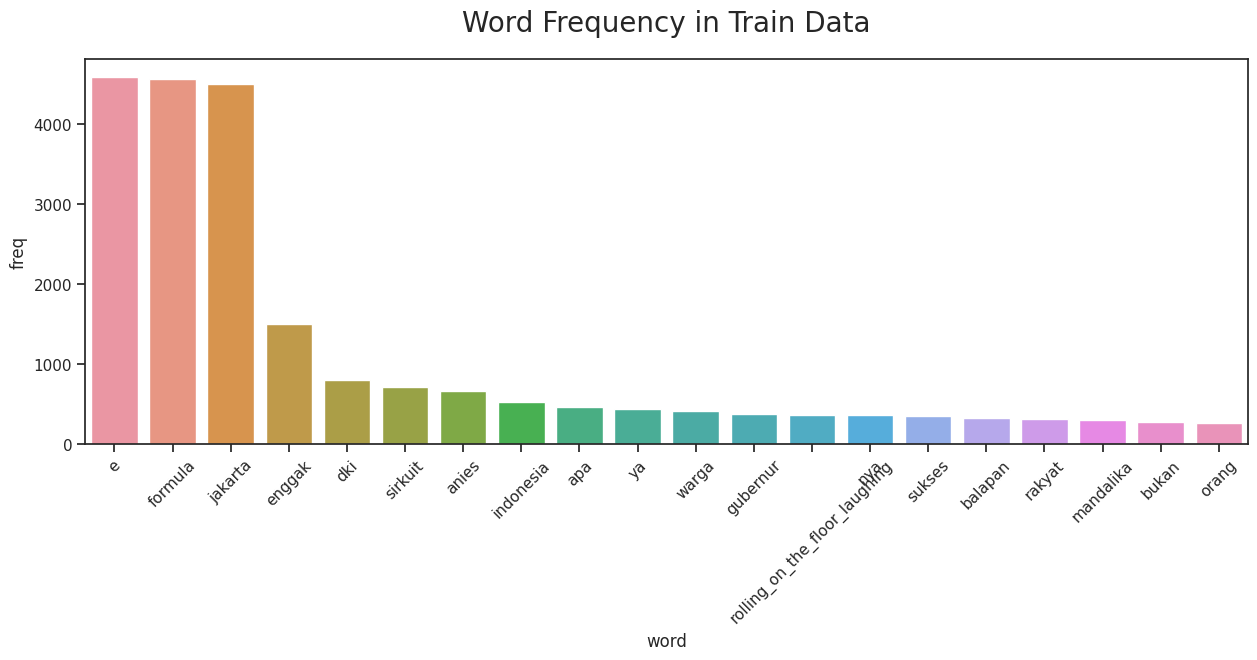

In [20]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

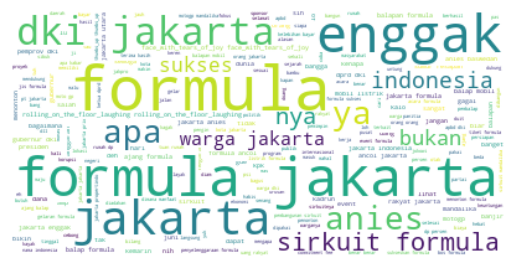

In [21]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
# train val split
train_set, val_set = train_test_split(df_preprocessed, test_size=0.2, stratify=df_preprocessed.sentiment)
val_set, test_set = train_test_split(val_set, test_size=0.5, shuffle=False)

In [23]:
def convert_data_to_examples(input_set,  DATA_COLUMN, LABEL_COLUMN):
  set_InputExamples = input_set.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  return set_InputExamples


In [24]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [25]:
def convert_data_to_tf_dataset(train, val, data_column, label_column, tokenizer):
  train_InputExamples = convert_data_to_examples(train, data_column, label_column)
  validation_InputExamples = convert_data_to_examples(val, data_column, label_column)
  
  train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
  train_data = train_data.shuffle(100).batch(32).repeat(2)
  
  validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
  validation_data = validation_data.batch(32)
  return train_data, validation_data


In [39]:
def bert_model(pretrained_model, from_pt=False):
  tokenizer = BertTokenizer.from_pretrained(pretrained_model)
  config = BertConfig.from_pretrained(pretrained_model)
  config.labels = 3
  
  base_model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=3, from_pt=from_pt)
  return base_model, tokenizer
model, tokenizer = bert_model('indolem/indobertweet-base-uncased', from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
DATA_COLUMN = 'tweets'
LABEL_COLUMN = 'sentiment'

train_data, validation_data = convert_data_to_tf_dataset(train_set, val_set, DATA_COLUMN, LABEL_COLUMN, tokenizer)

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
210/210 [==============================] - 191s 814ms/step - loss: 0.9643 - accuracy: 0.5636 - val_loss: 0.7620 - val_accuracy: 0.7434
Epoch 2/5
210/210 [==============================] - 168s 800ms/step - loss: 0.7357 - accuracy: 0.7022 - val_loss: 0.5853 - val_accuracy: 0.7674
Epoch 3/5
210/210 [==============================] - 168s 799ms/step - loss: 0.5951 - accuracy: 0.7588 - val_loss: 0.5473 - val_accuracy: 0.7818
Epoch 4/5
210/210 [==============================] - 168s 800ms/step - loss: 0.4989 - accuracy: 0.8133 - val_loss: 0.5257 - val_accuracy: 0.7962
Epoch 5/5
210/210 [==============================] - 168s 799ms/step - loss: 0.4250 - accuracy: 0.8444 - val_loss: 0.5275 - val_accuracy: 0.7914


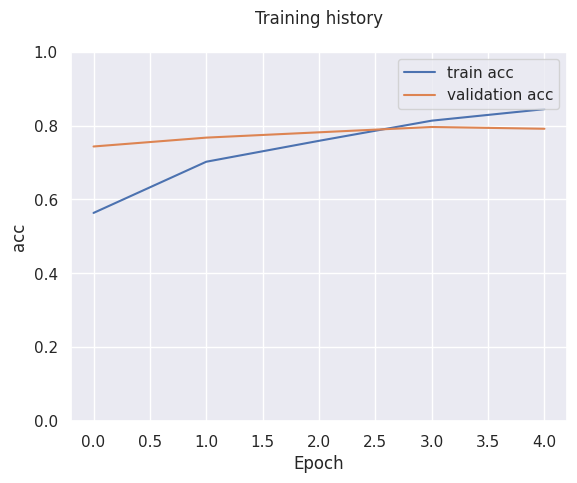

In [42]:
sns.set()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Overfit parah owkwokw

In [43]:
test_sentences = list(test_set["tweets"])
tf_batch = tokenizer(test_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels =  ["Positive", "Neutral", "Negative"]
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
test_pred = []
for i in range(len(test_sentences)):
  print(test_sentences[i], ": ", labels[label[i]])
  test_pred.append(label[i])
print(test_pred)

efek majunya jakarta anies hadirnya stadion jis amp formula e lembaga survey menawarkan amp menerima pesanan sesuai kehendak pemesan :  Positive
wkwkwkkwk dagelan kpk face_with_tears_of_joy giliran jeruk tangerine responsif giliran formula e krik krik giliran lubang resapan sstt dki jakarta terlalu sakti amp licin kpk sdg masuk angin :  Negative
menghalu menonton formula e jakarta langsung :  Neutral
formula e mingkem jakarta banjir kabur eh reuni peak 212 membela sih cabul sangat serius lo gubernur jakarta gubernurnya sih cabul :  Negative
bikin proyek formula e jakarta enggak seindah dibayangkan gubernur perencanaannya enggak matang alias abal abal face_with_hand_over_mouth :  Negative
tiket gratis ramai buzzer dikerahkan teriak² formula_e sukses faktanya formula_e jakarta rugi :  Negative
modal tuh formula e penonton 10 00 kapan cuannya hamburin duit rakyat jakarta :  Negative
semoga indonesia sukses gelaran balapan formula e jakarta 6 juni 2022 jakarta e prix 2022 :  Positive
wakil

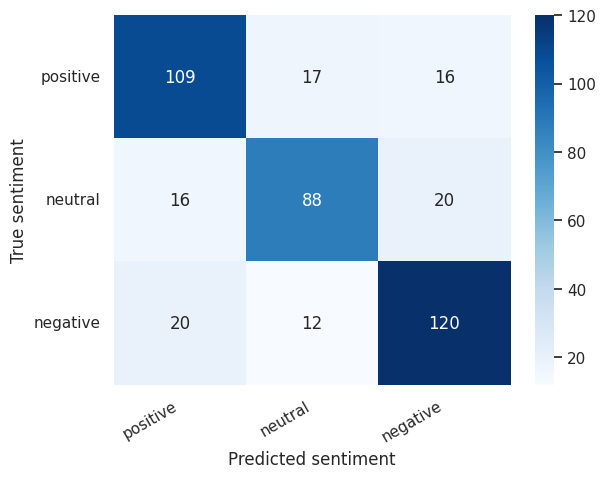

In [44]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(test_set.sentiment, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [45]:
print(classification_report(test_set.sentiment, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.75      0.77      0.76       142
     neutral       0.75      0.71      0.73       124
    negative       0.77      0.79      0.78       152

    accuracy                           0.76       418
   macro avg       0.76      0.76      0.76       418
weighted avg       0.76      0.76      0.76       418

